## Code 2

100%|██████████████████████████████████████████████████████████████████████████████| 700/700 [7:30:09<00:00, 38.58s/it]


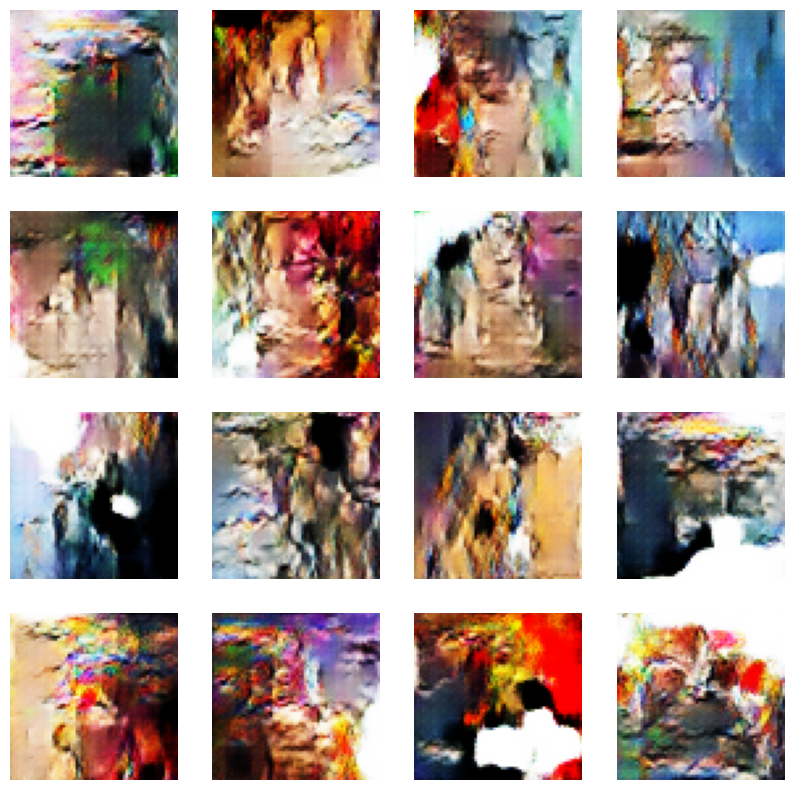

In [76]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Conv2DTranspose, Conv2D, LeakyReLU, Dropout, Flatten
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Chemin vers le dossier de données
data_folder = r"C:\Users\oulds\Downloads\one_piece"  # Assurez-vous de mettre à jour ceci avec le chemin réel

# Paramètres du GAN
image_width = 64
image_height = 64
channels = 3
latent_dim = 100
batch_size = 64

# Charger et prétraiter les images
def load_images_from_folder(data_folder, width, height):
    images = []
    for folder_name in os.listdir(data_folder):
        folder_path = os.path.join(data_folder, folder_name)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                try:
                    with Image.open(file_path) as img:
                        if img.mode == 'P': 
                            img = img.convert('RGBA')
                        img = img.resize((width, height))
                        img = img.convert('RGB')
                        images.append(np.array(img))
                except Exception as e:
                    print(e)
                    continue
    return np.array(images)


# Chargement des images
x_data = load_images_from_folder(data_folder, image_width, image_height)

# Normaliser les images
x_data = (x_data.astype(np.float32) - 127.5) / 127.5

# Créer des ensembles d'entraînement et de test
x_train, x_test = train_test_split(x_data, test_size=0.2, random_state=42)

# Créer le Dataset TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(len(x_train))
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(1)

# Construire le générateur
generator = Sequential([
    Dense(8 * 8 * 256, input_shape=(latent_dim,)),
    Reshape((8, 8, 256)),
    BatchNormalization(),
    Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(channels, kernel_size=4, strides=2, padding='same', activation='tanh')
])

# Construire le discriminateur
discriminator = Sequential([
    Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(image_width, image_height, channels)),
    LeakyReLU(alpha=0.2),
    Dropout(0.3),
    Conv2D(128, kernel_size=4, strides=2, padding='same'),
    LeakyReLU(alpha=0.2),
    Dropout(0.3),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# Compiler le discriminateur avec des paramètres ajustés
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])

# Désactiver l'entraînement du discriminateur lorsqu'on entraîne le GAN
discriminator.trainable = False

gan = Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))

# Fonction d'entraînement du GAN
def train_gan(gan, dataset, batch_size, latent_dim, epochs=50):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        for x_batch in dataset:
            # Entraîner le discriminateur
            noise = tf.random.normal(shape=(batch_size, latent_dim))
            generated_images = generator(noise)
            x_fake_and_real = tf.concat([generated_images, x_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(x_fake_and_real, y1)
            
            # Entraîner le générateur
            noise = tf.random.normal(shape=(batch_size, latent_dim))
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)

# Entraînement du GAN
train_gan(gan, train_dataset, batch_size, latent_dim, epochs=700)

def generate_and_save_images(model, test_input, epoch=0):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10, 10))
    
    num_images = predictions.shape[0]
    
    for i in range(num_images):
        plt.subplot(4, 4, i+1) 
        image = predictions[i, :, :, :] 
        image = (image * 127.5 + 127.5).numpy().astype('uint8')
        plt.imshow(image)
        plt.axis('off')
    
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

# Générez un vecteur de bruit pour les images
random_latent_vectors = tf.random.normal(shape=(16, latent_dim))

# Utilisez le modèle de générateur pour créer des images à partir du vecteur de bruit
generate_and_save_images(generator, random_latent_vectors)

## Code 1

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import torchvision

# Définir l'appareil (device) pour l'entraînement
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: N x z_dim x 1 x 1
            self._block(z_dim, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)  # Modification ici
        )

    def forward(self, x):
        return self.gen(x)


class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, 4, 2, 1),  # N x channels_img x 64 x 64 -> N x features_d x 32 x 32
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),  # N x features_d x 32 x 32 -> N x features_d*2 x 16 x 16
            self._block(features_d * 2, features_d * 4, 4, 2, 1),  # N x features_d*2 x 16 x 16 -> N x features_d*4 x 8 x 8
            self._block(features_d * 4, features_d * 8, 4, 2, 1),  # N x features_d*4 x 8 x 8 -> N x features_d*8 x 4 x 4
            nn.Conv2d(features_d * 8, 1, 4, 2, 0),  # N x features_d*8 x 4 x 4 -> N x 1 x 1 x 1
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3)  # Ajout du dropout ici
        )

    def forward(self, x):
        return self.disc(x).view(-1)





# Définir le Dataset personnalisé
class MangaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        for subdir, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith(('.png', '.jpg', '.jpeg')):  # Assurez-vous que ce sont des images
                    self.images.append(os.path.join(subdir, file))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")  # Convert to RGB if necessary
        if self.transform:
            image = self.transform(image)
        return image

# Fonction d'initialisation des poids
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# Hyperparamètres
lr = 0.0002
batch_size = 32
image_size = 64
channels_img = 3  # Utilisez 3 pour les images RGB
z_dim = 100
features_g = 64
features_d = 64
num_epochs = 1000

# Prétraitements à appliquer à chaque image
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalisation pour les images RGB
])

# Création du Dataset
dataset = MangaDataset(root_dir=r"C:\Users\oulds\Downloads\one_piece", transform=transform)

# Création du DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Créer le générateur et le discriminateur
gen = Generator(z_dim, channels_img, features_g).to(device)
disc = Discriminator(channels_img, features_d).to(device)


gen.apply(weights_init)
disc.apply(weights_init)


# Définir les pertes et les optimisateurs
opt_gen = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

# Fonction de perte
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, z_dim, 1, 1, device=device)  # 32 est un exemple de nombre d'images à générer


# Boucle d'entraînement
for epoch in range(num_epochs):
    for batch_idx, real in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake = gen(noise)

        # Entraînement du discriminateur
        disc_real = disc(real).view(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).view(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        # Entraînement du générateur
        output = disc(fake).view(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}")

            with torch.no_grad():
                # Générer des images fixes pour le suivi des progrès
                fixed_fake = gen(fixed_noise).detach().cpu()
                img_grid = torchvision.utils.make_grid(fixed_fake, padding=2, normalize=True)

                # Sauvegarder l'image générée
                torchvision.utils.save_image(img_grid, f'generated_images_epoch_{epoch}.png')